# Data Preprocessing

## Data Sources
**Michigan Inflation Expectation**

The Michigan Inflation Expectation dataset is a monthly time-series dataset that attempts to predict where the consumer price index will be a year from now.

https://fred.stlouisfed.org/series/MICH

**US CPI Rate**

https://fred.stlouisfed.org/series/CPALTT01USM657N

In [172]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [173]:
PATH_FFR_PRE_2008 = 'data/FFR_pre_2008.csv'
df_pre_2008 = pd.read_csv(PATH_FFR_PRE_2008, low_memory=False)

PATH_FFR_POST_2008 = 'data/FFR_post_2008.csv'
df_post_2008 = pd.read_csv(PATH_FFR_POST_2008, low_memory=False)

PATH_UNEMPLOYMENT = 'data/UNRATE.csv'
df_unemployment = pd.read_csv(PATH_UNEMPLOYMENT, low_memory=False)
df_unemployment['DATE'] = pd.to_datetime(df_unemployment['DATE'])
df_unemployment.columns = ['date', 'unemployment']

PATH_INFLATION = 'data/PCE_inflation.csv'
df_inflation = pd.read_csv(PATH_INFLATION, low_memory=False)
df_inflation['DATE'] = pd.to_datetime(df_inflation['DATE'])
df_inflation.columns = ['date', 'inflation']

PATH_EXPECTED_CPI = 'data/Michigan Inflation Expectation.csv'
df_expected_cpi = pd.read_csv(PATH_EXPECTED_CPI, low_memory=False)
df_expected_cpi['DATE'] = pd.to_datetime(df_expected_cpi['DATE'])
df_expected_cpi.columns = ['date', 'expected_cpi']

PATH_PCE = 'data/PCE.csv'
df_pce = pd.read_csv(PATH_PCE, low_memory=False)
df_pce['DATE'] = pd.to_datetime(df_pce['DATE'])
df_pce.columns = ['date', 'pce']


In [174]:
# concatenate pre- and post-2008 FFR data, impute value for Dec 2008
df_pre_2008.columns = ['date', 'ffr']
df_dec_2008 = pd.DataFrame({'date':['2008-12-01'], 'ffr':[.250000]})
df_post_2008.columns = ['date', 'ffr']

df = pd.concat([df_pre_2008, df_dec_2008, df_post_2008], ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df.isna().sum()

date    0
ffr     0
dtype: int64

In [175]:
print("FFR data")
print(df.head(5))

print("Unemployment data")
print(df_unemployment.head(5))

print("CPI data")
print(df_inflation.head(5))

print("Expected CPI data")
print(df_expected_cpi.head(5))

FFR data
        date       ffr
0 1994-01-01  3.000000
1 1994-02-01  3.223214
2 1994-03-01  3.330645
3 1994-04-01  3.608333
4 1994-05-01  3.991935
Unemployment data
        date  unemployment
0 1994-01-01           6.6
1 1994-02-01           6.6
2 1994-03-01           6.5
3 1994-04-01           6.4
4 1994-05-01           6.1
CPI data
        date  inflation
0 1994-01-01       2.36
1 1994-02-01       2.35
2 1994-03-01       2.41
3 1994-04-01       2.30
4 1994-05-01       2.27
Expected CPI data
        date  expected_cpi
0 1978-01-01           5.2
1 1978-02-01           6.4
2 1978-03-01           6.3
3 1978-04-01           6.7
4 1978-05-01           6.9


In [176]:
df['ffr_1m_change'] = df['ffr'] - df['ffr'].shift(1)  # 1-month change
# df['ffr_3m_change'] = df['ffr'] - df['ffr'].shift(3)  # 3-month change
# df['ffr_6m_change'] = df['ffr'] - df['ffr'].shift(6)  # 6-month change
# df['ffr_12m_change'] = df['ffr'] - df['ffr'].shift(12)  # 12-month change
# df['ffr_24m_change'] = df['ffr'] - df['ffr'].shift(24)  # 24-month change

# df= pd.merge(df, df_unemployment, left_on='date', right_on='date', how='outer')
df = pd.merge(df, df_unemployment, on='date', how='inner')
df= pd.merge(df, df_inflation, on='date', how='inner')
df= pd.merge(df, df_expected_cpi, on='date', how='inner')
df= pd.merge(df, df_pce, on='date', how='inner')

change_predictors = ['unemployment', 'inflation', 'expected_cpi', 'pce']
month_shifts = [1, 3, 6, 12, 24]
for predictor in change_predictors:
    for shift in month_shifts:
        df[predictor+f'_{shift}m_change'] = df[predictor] - df[predictor].shift(shift)


In [177]:
df.columns

Index(['date', 'ffr', 'ffr_1m_change', 'unemployment', 'inflation',
       'expected_cpi', 'pce', 'unemployment_1m_change',
       'unemployment_3m_change', 'unemployment_6m_change',
       'unemployment_12m_change', 'unemployment_24m_change',
       'inflation_1m_change', 'inflation_3m_change', 'inflation_6m_change',
       'inflation_12m_change', 'inflation_24m_change',
       'expected_cpi_1m_change', 'expected_cpi_3m_change',
       'expected_cpi_6m_change', 'expected_cpi_12m_change',
       'expected_cpi_24m_change', 'pce_1m_change', 'pce_3m_change',
       'pce_6m_change', 'pce_12m_change', 'pce_24m_change'],
      dtype='object')

In [178]:
df.describe()

,date,ffr,ffr_1m_change,unemployment,inflation,expected_cpi,pce,unemployment_1m_change,unemployment_3m_change,unemployment_6m_change,...,expected_cpi_1m_change,expected_cpi_3m_change,expected_cpi_6m_change,expected_cpi_12m_change,expected_cpi_24m_change,pce_1m_change,pce_3m_change,pce_6m_change,pce_12m_change,pce_24m_change
count,369,369.000000,368.000000,369.000000,369.000000,369.000000,369.000000,368.000000,366.000000,363.000000,...,368.000000,366.000000,363.000000,357.000000,345.000000,368.000000,366.000000,363.000000,357.000000,345.000000
mean,2009-05-01 16:00:00,2.605512,0.006250,5.596206,2.169051,3.049593,10442.041463,-0.006793,-0.019399,-0.037741,...,-0.000272,-0.000546,0.001377,0.007003,0.044638,41.954348,125.524317,250.524793,498.563025,988.763478
min,1994-01-01 00:00:00,0.250000,-0.975806,3.400000,0.800000,0.400000,4585.100000,-2.200000,-4.800000,-8.000000,...,-1.800000,-2.600000,-3.400000,-2.500000,-2.500000,-1576.100000,-2609.900000,-2383.000000,-2055.600000,-1604.000000
25%,2001-09-01 00:00:00,0.250000,0.000000,4.300000,1.730000,2.700000,7121.700000,-0.100000,-0.200000,-0.400000,...,-0.100000,-0.200000,-0.200000,-0.300000,-0.400000,18.675000,76.625000,154.550000,314.800000,642.900000
50%,2009-05-01 00:00:00,1.891667,0.000000,5.100000,2.040000,2.900000,10035.300000,0.000000,-0.100000,-0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,36.800000,113.000000,215.700000,432.200000,853.000000
75%,2017-01-01 00:00:00,5.250000,0.000000,6.100000,2.370000,3.200000,13005.900000,0.100000,0.100000,0.100000,...,0.100000,0.200000,0.250000,0.300000,0.400000,58.550000,154.875000,278.600000,526.100000,1030.700000
max,2024-09-01 00:00:00,6.500000,0.700000,14.800000,4.990000,5.400000,20024.300000,10.400000,11.200000,11.200000,...,1.400000,1.700000,2.400000,2.300000,3.300000,1017.300000,2069.400000,2491.600000,3680.600000,5259.400000
std,NaN,2.204385,0.178279,1.802546,0.732881,0.684380,3984.583035,0.596568,1.007686,1.299291,...,0.334851,0.519799,0.666212,0.768613,0.955085,135.081039,245.487647,315.489780,471.779327,727.529503


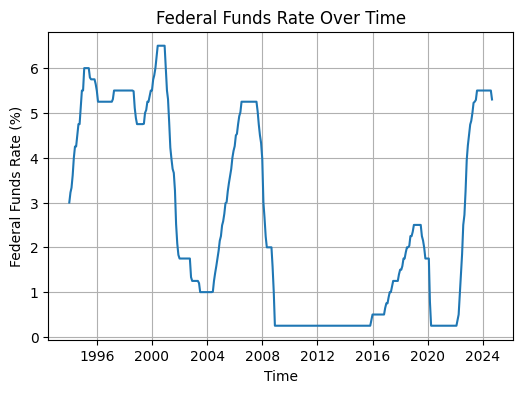

In [179]:
plt.figure(figsize=(6, 4))
plt.plot(df.date, df.ffr)
plt.title('Federal Funds Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Federal Funds Rate (%)')
plt.grid()
plt.show()

In [180]:
date = pd.to_datetime('1994-01-01')
month = pd.DateOffset(months=1)
while date < pd.to_datetime('2024-10-01'):
    if date not in df['date'].values:
        print('missing: '+str(date))
    date += month

In [181]:
df = df.dropna()

X = df.drop(columns=['date', 'ffr', 'ffr_1m_change'])
X['unemployment_inflation'] = X['unemployment'] * X['inflation']
X['unemployment_expected_cpi'] = X['unemployment'] * X['expected_cpi']
X['inflation_expected_cpi'] = X['inflation'] * X['expected_cpi']
y = df['ffr_1m_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Coefficients: [ 1.77268900e-02 -1.15882429e-01 -2.03444386e-01  3.39568129e-06
  1.05034288e-02 -1.30721246e-02 -6.43884294e-03 -1.55580752e-02
 -1.06936412e-02 -3.98467628e-02  8.18885301e-02 -2.18897287e-01
  1.29793410e-01 -3.02580586e-02  2.85047575e-02  2.66907592e-02
  5.30599048e-02  3.64473847e-03  3.32986409e-03  2.12972598e-04
 -2.68320830e-06 -9.78671088e-06 -6.42111638e-05  4.20919540e-05
 -1.23332835e-02  5.10458425e-03  5.79257101e-02]
Intercept: 0.3726251744008097


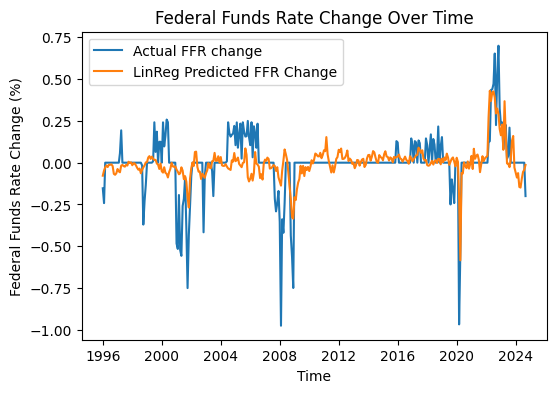

In [188]:
df.loc[:, 'predicted_ffr_change'] = model.predict(X)

plt.figure(figsize=(6, 4))
plt.plot(df.date, df.ffr_1m_change, label='Actual FFR change')
plt.plot(df.date, df.predicted_ffr_change, label='LinReg Predicted FFR Change')
plt.legend()
plt.title('Federal Funds Rate Change Over Time')
plt.xlabel('Time')
plt.ylabel('Federal Funds Rate Change (%)')
# plt.grid()
plt.show()